In [1]:
# Import modules
import datetime
import spiceypy
import numpy as np
import pandas as pd

# Load the SPICE kernels via a meta file
spiceypy.furnsh('kernel_meta.txt')

# Create an initial and ending time date-time object that is converted to a
# string
INIT_TIME_UTC_STR = datetime.datetime(year=2020, month=1, day=1) \
                        .strftime('%Y-%m-%dT%H:%M:%S')
END_TIME_UTC_STR = datetime.datetime(year=2020, month=6, day=1) \
                        .strftime('%Y-%m-%dT%H:%M:%S')

# Convert to Ephemeris Time (ET) using the SPICE function utc2et
INIT_TIME_ET = spiceypy.utc2et(INIT_TIME_UTC_STR)
END_TIME_ET = spiceypy.utc2et(END_TIME_UTC_STR)

# Set the number of seconds per hours. This value is used to compute the phase
# angles in 1 hour steps (the ET is given in seconds)
DELTA_HOUR_IN_SECONDS = 3600.0
TIME_INTERVAL_ET = np.arange(INIT_TIME_ET, END_TIME_ET, DELTA_HOUR_IN_SECONDS)

In [2]:
# All our computed parameters, positions etc. shall be stored in a pandas
# dataframe. First, we create an empty one
INNER_SOLSYS_DF = pd.DataFrame()

# Set the column ET that stores all ETs
INNER_SOLSYS_DF.loc[:, 'ET'] = TIME_INTERVAL_ET

# The column UTC transforms all ETs back to a UTC format. The function
# spicepy.et2datetime is NOT an official part of SPICE (there you can find
# et2utc).
# However this function returns immediately a date-time object
INNER_SOLSYS_DF.loc[:, 'UTC'] = \
    INNER_SOLSYS_DF['ET'].apply(lambda x: spiceypy.et2datetime(et=x))

# Compute now the phase angle between Venus and Sun as seen from Earth
#
# For this computation we need the SPICE function phaseq. et is the ET. Based
# on SPICE's logic the target is the Earth (399) and the illumination source
# (illmn) is the Sun (10), the observer (obsrvr) is Venus with the ID 299.
# We apply a correction that considers the movement of the planets and the
# light time (LT+S).
INNER_SOLSYS_DF.loc[:, 'EARTH_VEN2SUN_ANGLE'] = \
    INNER_SOLSYS_DF['ET'].apply(lambda x: \
                                    np.degrees(spiceypy.phaseq(et=x, \
                                                               target='399', \
                                                               illmn='10', \
                                                               obsrvr='299', \
                                                               abcorr='LT+S')))

In [3]:
# Compute the angle between the Moon and the Sun. We apply the same function
# (phaseq). The Moon NAIF ID is 301
INNER_SOLSYS_DF.loc[:, 'EARTH_MOON2SUN_ANGLE'] = \
    INNER_SOLSYS_DF['ET'].apply(lambda x: \
                                    np.degrees(spiceypy.phaseq(et=x, \
                                                               target='399', \
                                                               illmn='10', \
                                                               obsrvr='301', \
                                                               abcorr='LT+S')))

In [4]:
# Compute finally the phase angle between the Moon and Venus
INNER_SOLSYS_DF.loc[:, 'EARTH_MOON2VEN_ANGLE'] = \
    INNER_SOLSYS_DF['ET'].apply(lambda x: \
                                    np.degrees(spiceypy.phaseq(et=x, \
                                                               target='399', \
                                                               illmn='299', \
                                                               obsrvr='301', \
                                                               abcorr='LT+S')))

In [5]:
# Are photos of both objects "photogenic"? Let's apply a pandas filtering
# with some artificially set angular distances and create a binary tag for
# photogenic (1) and non-photogenic (0) constellations
#
# Angular distance Venus - Sun: > 30 degrees
# Angular distance Moon - Sun: > 30 degrees
# Angular distance Moon - Venus: < 10 degrees
INNER_SOLSYS_DF.loc[:, 'PHOTOGENIC'] = \
    INNER_SOLSYS_DF.apply(lambda x: 1 if (x['EARTH_VEN2SUN_ANGLE'] > 30.0) \
                                       & (x['EARTH_MOON2SUN_ANGLE'] > 30.0) \
                                       & (x['EARTH_MOON2VEN_ANGLE'] < 10.0) \
                                      else 0, axis=1)

In [6]:
# Print the temporal results (number of computed hours, and number of
# "photogenic" hours)
print('Number of hours computed: %s (around %s days)' \
      % (len(INNER_SOLSYS_DF), round(len(INNER_SOLSYS_DF) / 24)))

print('Number of photogenic hours: %s (around %s days)' \
      % (len(INNER_SOLSYS_DF.loc[INNER_SOLSYS_DF['PHOTOGENIC'] == 1]), \
         round(len(INNER_SOLSYS_DF.loc[INNER_SOLSYS_DF['PHOTOGENIC'] == 1]) \
               / 24)))

Number of hours computed: 3649 (around 152 days)
Number of photogenic hours: 143 (around 6 days)


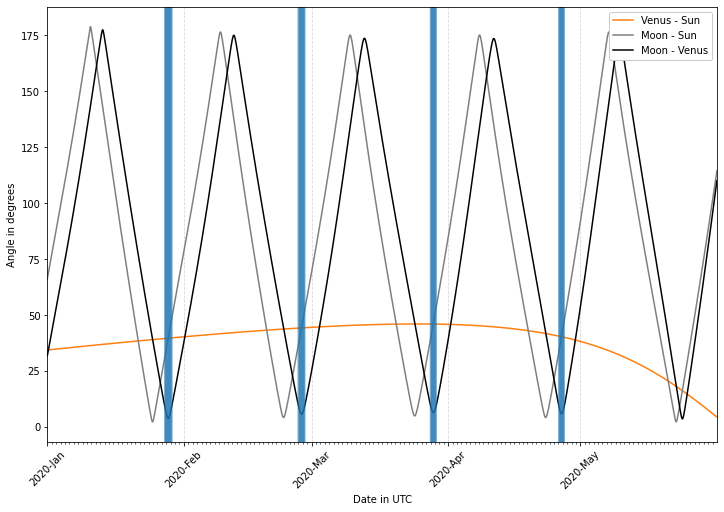

In [7]:
# Import the matplotlib library
from matplotlib import pyplot as plt
import matplotlib.dates as matpl_dates

# Set a figure
FIG, AX = plt.subplots(figsize=(12, 8))

# Plot the miscellaneous phase angles; apply different colors for the curves
# and set a legend label
AX.plot(INNER_SOLSYS_DF['UTC'], INNER_SOLSYS_DF['EARTH_VEN2SUN_ANGLE'], \
        color='tab:orange', label='Venus - Sun')

AX.plot(INNER_SOLSYS_DF['UTC'], INNER_SOLSYS_DF['EARTH_MOON2SUN_ANGLE'], \
        color='tab:gray', label='Moon - Sun')

AX.plot(INNER_SOLSYS_DF['UTC'], INNER_SOLSYS_DF['EARTH_MOON2VEN_ANGLE'], \
        color='black', label='Moon - Venus')

# Set a label for the x and y axis accordingly
AX.set_xlabel('Date in UTC')
AX.set_ylabel('Angle in degrees')

# Set limits for the x and y axis
AX.set_xlim(min(INNER_SOLSYS_DF['UTC']), max(INNER_SOLSYS_DF['UTC']))

# Set a grid
AX.grid(axis='x', linestyle='dashed', alpha=0.5)

# Set a month and day locator for the plot
AX.xaxis.set_major_locator(matpl_dates.MonthLocator())
AX.xaxis.set_minor_locator(matpl_dates.DayLocator())

# Set a format for the date-time (Year + Month name)
AX.xaxis.set_major_formatter(matpl_dates.DateFormatter('%Y-%b'))

# Iterate through the "photogenic" results and draw vertical lines where the
# "photogenic" conditions apply
for photogenic_utc in INNER_SOLSYS_DF.loc[INNER_SOLSYS_DF['PHOTOGENIC'] == 1]['UTC']:
    AX.axvline(photogenic_utc, color='tab:blue', alpha=0.2)

# Create the legend in the top right corner of the plot
AX.legend(fancybox=True, loc='upper right', framealpha=1)

# Rotate the date-times
plt.xticks(rotation=45)

# Saving the figure in high quality
plt.savefig('VENUS_SUN_MOON.png', dpi=300)